Подключаем библиотеки и cuda

In [1]:
import os
import glob
import random

import torch
import numpy as np
import cv2
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

Класс для датасета

In [3]:
class ColorDataset(Dataset):
    
    def __init__(self, rootdir, transform=None) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
            image = self.transform(image)

        return (image, label)

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5),
    ]
    
)

Данные test хранятся в папке без деления на классы, что не даёт удобно проверить результаты. Для обучения данные разделим train на 2 набора train(80%) и test(20%).

In [5]:
import os

current_directory = os.getcwd()
DATA_PATH = os.path.join(current_directory, 'data')

In [6]:
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

batch_size = 64
dataset = ColorDataset(DATA_PATH, transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([ 3,  3, 10,  4,  5,  3, 10,  6,  3, 10,  2,  5,  8,  1,  8,  9,  4,  3,
         8,  5,  3,  1,  2,  4,  1, 11,  0, 11,  7, 10, 10,  6,  1,  1,  7,  5,
        11,  0,  7, 11,  1,  7, 10,  4,  8,  0,  4,  9,  7,  1,  4,  2,  1,  5,
         5,  1,  0, 11,  6, 11, 11,  5,  9,  2])


In [8]:
# выход с последнего слоя
len(classes.values())       

12

In [9]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes.values()))

model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\123/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [10]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):

            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*batch_size
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('accuracy', acc)

        torch.save(model, f'ResNet_color_classifier_{epoch}_epo_{acc}_acc.pt')

In [11]:
train(train_loader, model, loss_function, optimizator, 6)

loss = 2.6476290225982666, samples = 64
accuracy 0.625
loss = 1.225096344947815, samples = 128
accuracy 0.6770833333333334
loss = 0.9889848232269287, samples = 192
accuracy 0.6971153846153846
loss = 0.9012218713760376, samples = 256
accuracy 0.7091346153846154
loss = 0.8483155965805054, samples = 320
accuracy 0.7123397435897436
loss = 0.8098057508468628, samples = 384
accuracy 0.7147435897435898


In [12]:
model(x.cuda()).size()

torch.Size([64, 12])

Рассчёт метрик

In [13]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def calculate_metrics(model, data_loader, device):
    
    '''
    Функция для рассчёта метрик 
    Accuracy, Recall, Precision
    
    Вход: model, data_loader, device
    Выход: значения метрик accuracy, precision, recall
    '''
    
    correct_predictions = 0
    total_predictions = 0
    num_classes = len(classes.values())

    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for data in data_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        _, predicts = torch.max(model(inputs), 1)  # Получаем классы с максимальной вероятностью
                    
        total_predictions += labels.size(0)
        correct_predictions += (predicts == labels).sum().item()
        
        for i in range(len(labels)):
            if predicts[i] == labels[i]:
                true_positives[labels[i].item()] += 1
            else:
                false_positives[predicts[i].item()] += 1
                false_negatives[labels[i].item()] += 1
                
        recall, precision = 0, 0
                
        for i in range(num_classes):
            if (true_positives[i] + false_positives[i]) > 0:
                precision += true_positives[i] / (true_positives[i] + false_positives[i])
    
            if (true_positives[i] + false_negatives[i]) > 0:
                recall += true_positives[i] / (true_positives[i] + false_negatives[i]) 

        accuracy = correct_predictions / total_predictions
        precision /= num_classes
        recall /= num_classes
    
    return accuracy, precision, recall


In [15]:
model.to(device)
accuracy, precision, recall = calculate_metrics(model, test_loader, device)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')

Accuracy: 71.47%
Precision: 71.77%
Recall: 68.79%


In [16]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to(device)), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))

20


In [17]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
model.to("cpu")
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [20]:
cm.shape

(12, 12)

<Figure size 20000x20000 with 0 Axes>

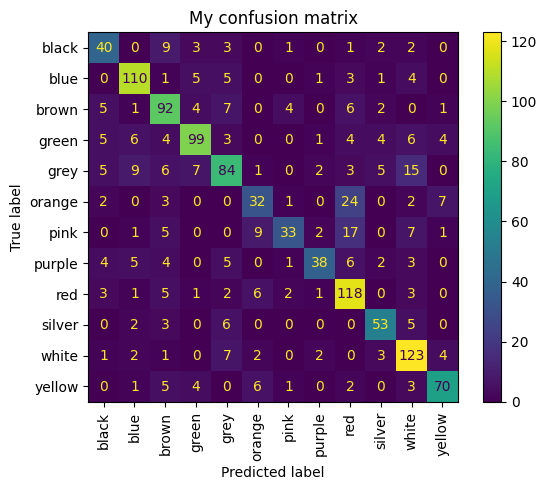

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(200,200))
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuple(classes.values()))
disp.plot()
plt.title("My confusion matrix")
plt.xticks(rotation=90)
plt.show()